In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ase.io as aio
import numpy as np
import numba
import pandas as pd
from scipy.spatial import cKDTree
from toolz.curried import pipe, curry
import atom_stat as astat

In [3]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [4]:
def draw(im):
    im1 = np.squeeze(im)
    plt.imshow(im1)
    plt.colorbar()
    plt.grid(False)
    plt.show()

## Estimate Distrubance in 3D

### Load coordinates of all atoms

In [6]:
fname = fname = "data/dump.clean"
df = pd.read_table(fname, 
                   delimiter=" ",
                   skiprows=9,
                   header=None)
coords = np.asarray(df.iloc[:,2:5])

### Load coordinates of disturbed atom here and save them in the coords0 file
### They can be computed using ovito - Common Neighbour Analysis and saved in an xyz file 
### The xyz file if available can be read with ase usin the following code snippet:

         atom = aio.read("coords/data_%d_new.xyz" % run)
         
         coords0 = atom.get_positions()

### Right now I am randomly choosing a 100 atoms for which I will compute the Two Point Statistics

In [7]:
ind = np.random.randint(10000, coords.shape[0], 100)
coords0 = coords[ind]

### Compute the vector counts and save them in a matrix called box

In [8]:
r_stat = 8 # radius of the statistics
len_pixel = 10 # voxel size

In [9]:
%%time
box = astat.get_voxelizedStats_tree(coords, coords0, r_stat, len_pixel)

CPU times: user 534 ms, sys: 24.3 ms, total: 558 ms
Wall time: 356 ms


### Visualize the vector counts

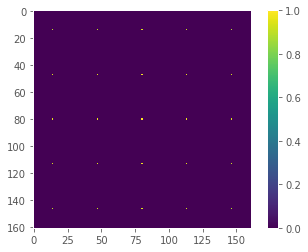

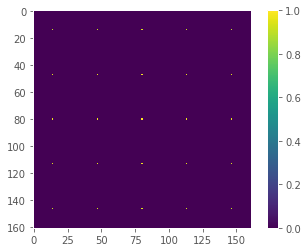

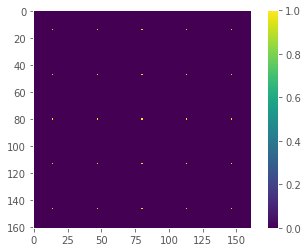

In [10]:
idx = int(r_stat * len_pixel)
draw(box[:,:, idx])
draw(box[:, idx, :])
draw(box[idx,:,:])

### Compute a smoothening filter for two point statistics

In [11]:
r_s = 1.0 # radius of the smoothening filter
new_shape = np.asarray(box.shape) + int(2 * r_s * len_pixel)

In [14]:
fs = pipe(r_s, 
          lambda r_s: astat.sphere(r_s * len_pixel),
          lambda s: astat.padder(s, new_shape), 
          lambda s: astat.imfilter(s, f_data=s) / np.count_nonzero(s))

### Visualize the smoothening filter

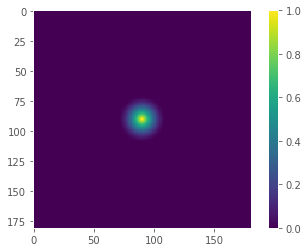

In [15]:
idx = int((r_stat + r_s) * len_pixel)
draw((fs[:,:, idx]))

## Apply the smoothening filter to the box

In [16]:
%%time
box1 = pipe(box, 
            lambda s: astat.padder(s, new_shape), 
            lambda s: astat.imfilter(s, f_data=fs))

CPU times: user 1.58 s, sys: 268 ms, total: 1.85 s
Wall time: 924 ms


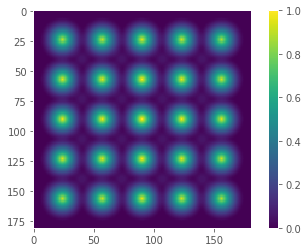

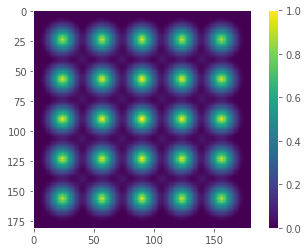

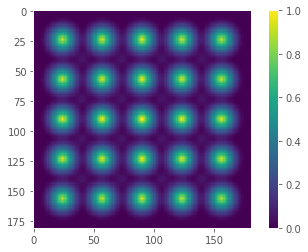

In [17]:
idx = int((r_stat + r_s) * len_pixel)
draw(box1[:,:, idx])
draw(box1[:, idx, :])
draw(box1[idx,:,:])